# Employee Retention Problem Goal: 

* Predict when employees are going to quit by understanding the main drivers of employee churn.
* What are the main factors that drive employee churn? Do they make sense? Explain your findings.
* What might you be able to do for the company to address employee Churn, what would be follow-up actions?
* If you could add to this data set just one variable that could help explain employee churn, what would that be?


## Solution

**Takeaways: **
The company needs to focus on a range of factors to increase employee retention. A generalized solution cannot be applied to all departments or companies. 


Observation on who quits more:
* Employees in 50K to 200K within 1-2 years of employments and more than 5 years of seniority quit more.
* Employees in customer service, marketing and sales with salaries lower than 200K  
* Employees in Data science and Engineering with salaries in 150K- 250K 
* Company 12 in speciifc, has trouble with low salories and more quitting

For predicting which employees quit, Running a random forest classifier on the the final data, gives an accuracy of 0.80

Recommendations:
Employees stay longer who are paid more with higher experience in high paying jobs and those with lower salaries  and high expereicne in non high paying jobs. People in between leave the most. In order to tackle employee churn, its needed that the focus is on a strategy to increase slary with increasing expereince, could also be in terms of bonuses based on performance. Tailoring bonues and salary increase to department can control employee churn in these cases.

Next:
- More data needed on:
    - average hours worked per week. 
    - date an employee received a raise/promotion
    - Bonuses and persformances received  and their dates
    - More personnel information within each departments
- Using other models like XGBoost or techniques like Survival analysis would also be better here .

With all this a more sophisticated salary- employee relationship could be understood and better strategies to overcome employee chrun



 



## Table of contents:
1. [Loading Data](#dataloading)  

2. [EDA](#eda)  
     
      a. [Number of employees who have quit so far](#NoEmp)  
      
      b. [Effect of salary on quitting ](# Quitting Vs salary)  
      
      c. [Effect of years worked on quitting ](#Quitting Vs years)  
      
      d. [Effect of Seniority on quitting](#Quitting Vs Seniority)  
      
      e. [Effect of department on quitting](# quitting vs department)  
      
      f. [Distribution of dept,salary and quitting](#dept and sal)
      
      g. [Distribution of company ,salary and quitting](#comp and sal) 
      
      h. [Summary table](#Summary table)
      
    

3. [Creating Model](#Creating Model)

   a. [Creating Final data](#Creating Final data)
   
   b. [Model Pipeleine and evaluation for Random Forest and Logistoc regression](#Model Pipeleine)
    
   b. [Prediction and Metrics](#model and metrics)
   
   
   4. [Applying a random forest model](#RFModel)
   

    
    
    
[Conclusion](#conclusion)

## Import libraries 

In [84]:
# Python imports
import itertools

# Data imports
import pandas as pd
import numpy as np
import seaborn as sns

# Viz imports
import matplotlib.pyplot as plt
%matplotlib inline

## Load data  <a name='dataloading'></a>

In [86]:
df = pd.read_csv('employee_retention_data.csv')
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB
None
         employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530      3.426969     14.127803  138183.345478
std    288909.026101      2.700011      8.089520   76058.184573
min        36.000000      1.000000      1.000000   17000.000000
25%    250133.750000      1.000000      7.000000   79000.000000
50%    500793.000000      2.000000     14.000000  123000.000000
75%    753137.250000      5.000000     21.000000  187000.000000
max    999969.000000     12.000000     99.000000  4080

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


## EDA <a name='eda'></a>

** Checking for unique employees and other columns **

so there is no repetition in number of employees

In [87]:
print(len(df))
print('Unique employee id ', df['employee_id'].nunique())
print('Unique depts ',df['dept'].nunique())
print('Unique salary ',df['salary'].nunique())
print('Unique seniority',df['seniority'].nunique())
print('Unique company id ',df['company_id'].nunique())

24702
Unique employee id  24702
Unique depts  6
Unique salary  367
Unique seniority 31
Unique company id  12


** Checking for null values **

Only quit date column has null values. This corresponds to number of emplyees who have not quit

In [88]:
# Looking for null values in the data
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

** check for duplicates ** 

In [89]:
df = df.drop_duplicates().copy()
len(df)

24702

** Number of employees who have quit so far **  <a name='#NoEmp'></a>

Looks like more people have quit

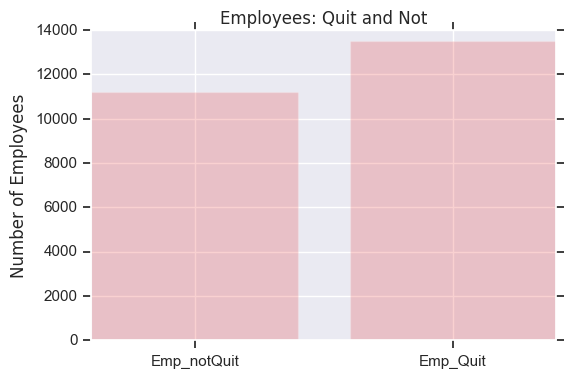

In [90]:
Emp_notQuit=df['quit_date'].isnull().sum()
Emp_Quit= df['employee_id'].count()-Emp_notQuit
# print('Number of employees who have not quit: %d' %Emp_notQuit)
# print('Number of employees who have quit: %d' %Emp_Quit)
labels = ('Emp_notQuit','Emp_Quit')
index = np.arange(len(labels))
plt.bar(index, [Emp_notQuit,Emp_Quit], align='center', alpha=0.2)
plt.xticks(index, labels)
plt.ylabel('Number of Employees')
plt.title('Employees: Quit and Not')
plt.show()
 

** Creating Quit Column  and days emplyed based on start and join dates **

** 1)  Creating quit column based on NA value in quit_date **

In [91]:
df['Not_quit']=df['quit_date'].isnull().astype(int)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Not_quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,1
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


** 2) Converting start date and end date into years **

In [92]:

#fill quit_date na with one day after data_collection date
df.quit_date.fillna('2015-12-14',inplace=True)

#convert join_date and quit_date into date_time object
df.quit_date = pd.to_datetime(df.quit_date)
df.join_date = pd.to_datetime(df.join_date)


#get a duration column by days
NumDays=(df.quit_date-df.join_date).dt.days


df['years_worked']=round((NumDays/365),2)

df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Not_quit,years_worked
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,1.60
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,0.93
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-14,1,1.17
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,1.07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,2.85



** Checking for ouliers**

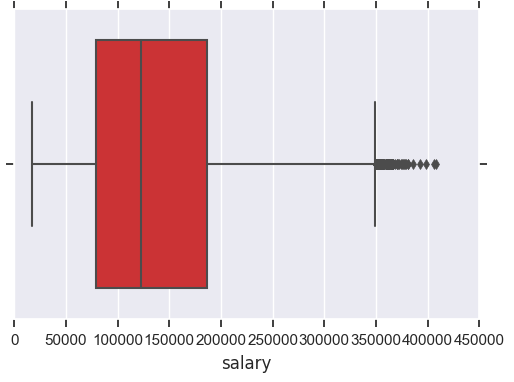

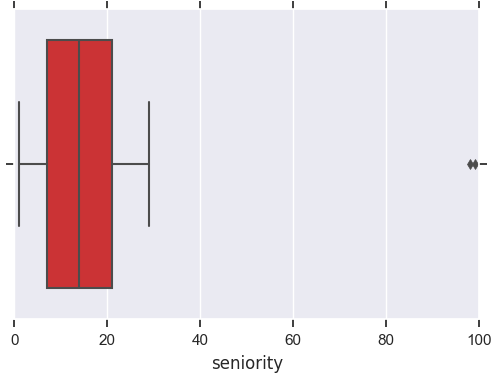

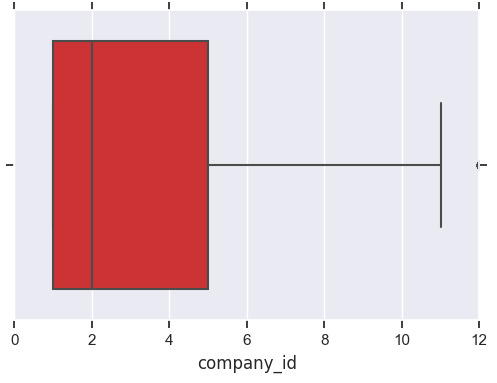

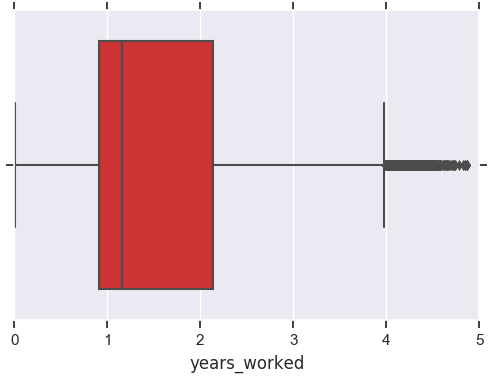

In [95]:
#check outliers for numeric values
numeric_columns = ['salary','seniority','company_id','years_worked']
for i in numeric_columns:
    sns.boxplot(i,data=df)
    plt.show()

** ISSUE: we see that seniority has a lot of outliers**

**  solve: Impute the Seniority coloumn outliers with median **

In [96]:
# mark zero values as missing or NaN
df['seniority']=df['seniority'].replace(df[(df['seniority']>30)]['seniority'], np.NaN)
# fill missing values with mean column values
df['seniority'].fillna(df['seniority'].median(), inplace=True)
# count the number of NaN values in each column
print(df['seniority'].isnull().sum())

0


## Distributions

Checking why people leave with respect to

- Salary
- Seniority
- Department
- Company ID
- Department and Salary combined
-  company id  and salary combined

** Distribution of Quitting Vs salary ** <a name=' Quitting Vs salary'></a>

Here we see that more employees in 100K to 200K salary range quit more 

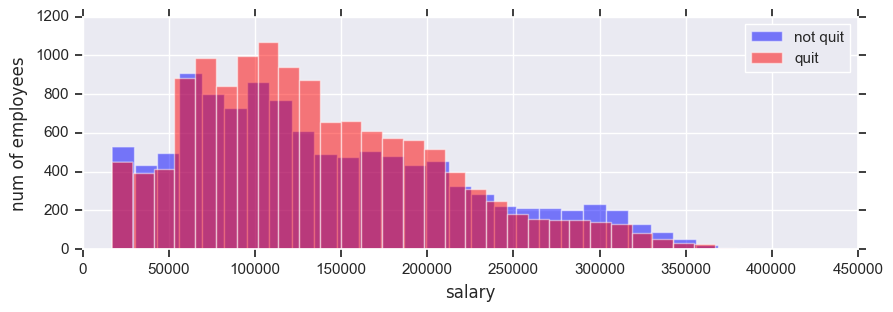

In [97]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['salary'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['salary'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('salary')
plt.ylabel('num of employees')
plt.show()

** Distribution of Quitting Vs years worked **  <a name=' Quitting Vs years'></a>


Here we see that more employees in 1-2 year range quit more 

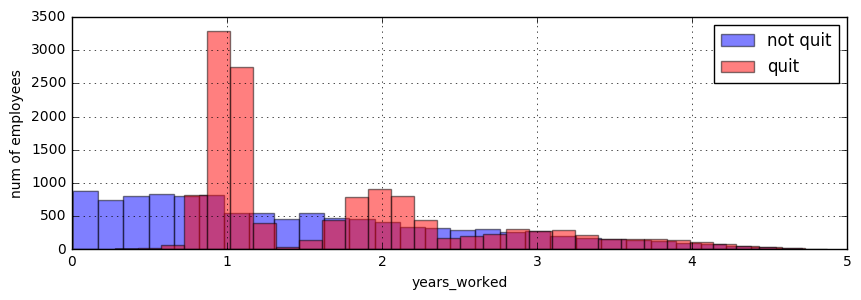

In [13]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['years_worked'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['years_worked'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('years_worked')
plt.ylabel('num of employees')
plt.show()

**  3) Distribution of qutting vs seniority **

Here we see that people with more than 5 years of seniority quit more

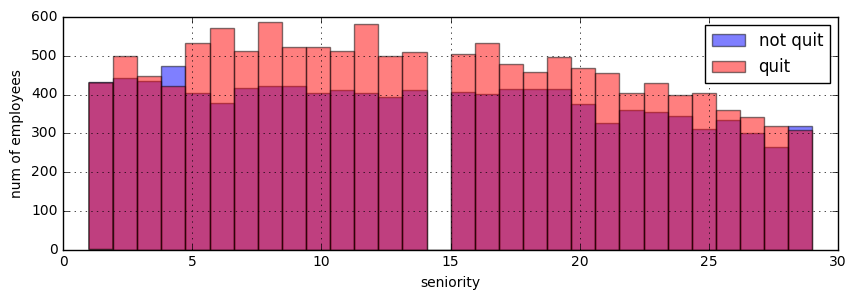

In [16]:
plt.figure(figsize=(10,3))
df[df['Not_quit']==1]['seniority'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not quit')
df[df['Not_quit']==0]['seniority'].hist(alpha=0.5,color='red',
                                              bins=30,label='quit')
plt.legend()
plt.xlabel('seniority')
plt.ylabel('num of employees')
plt.show()

**  Distribution of  quitting vs department **  <a name=' quitting vs department'></a>


Here we see that employees in customer service, marketing and sales are quitting more

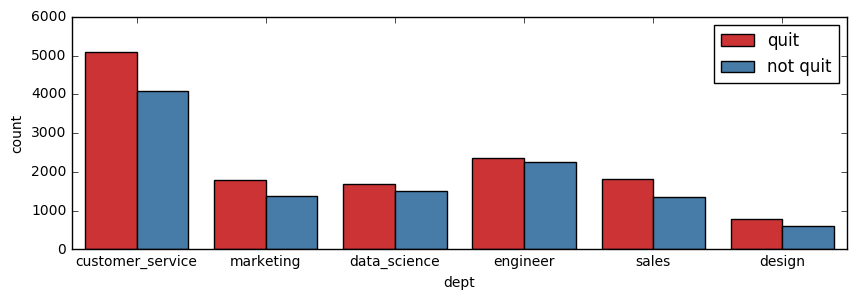

In [17]:
plt.figure(figsize=(10,3))
sns.countplot(x='dept',hue='Not_quit',data=df,palette='Set1')
plt.legend(('quit', 'not quit'))
plt.show()

** Distribution of dept vs salary and quitting **  <a name='dept and sal'></a>


Here we see that employees in customer service, marketing and sales are quitting more as they have salaries lower than 200K
Data scenie and engineers quit more int he salary range of 150K- 250K

C:\Users\PG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


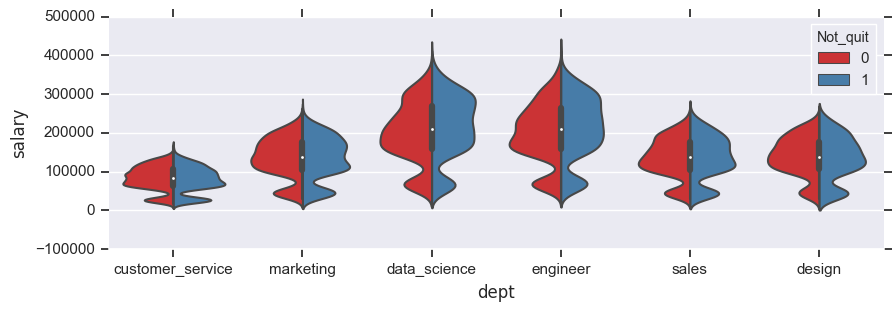

In [18]:
plt.figure(figsize=(10,3))

quit = (df.Not_quit == 0)
not_quit = (df.Not_quit == 1)

sns.set(palette="Set1")
sns.violinplot(x="dept", y="salary", hue="Not_quit",split=True,data=df)
sns.despine(left=True)
# plt.legend(('quit', 'not quit'))

plt.show()

**  Distribution of  quitting vs company ID **

Just shows that employees are quitting in all companies

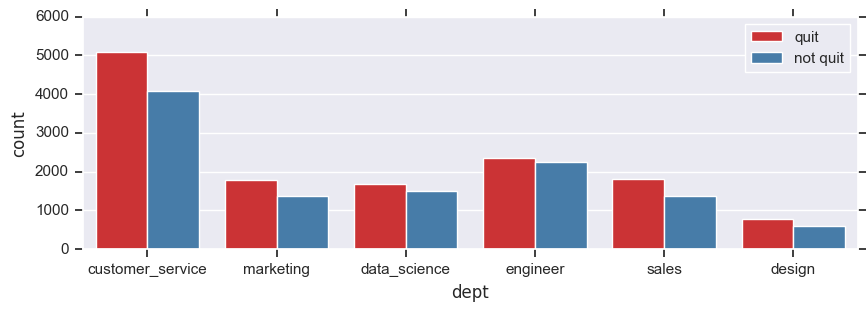

In [107]:
plt.figure(figsize=(10,3))
sns.countplot(x='dept',hue='Not_quit',data=df,palette='Set1')
plt.legend(('quit', 'not quit'))
plt.show()

** Distribution  of company id vs salary and quitting **  <a name='comp and sal'></a>

All companies have more quitting for employees between the 50k-200k range. 
Here we see that employees in company 12 is in trouble with low salaraiesa and more quitting


C:\Users\PG\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


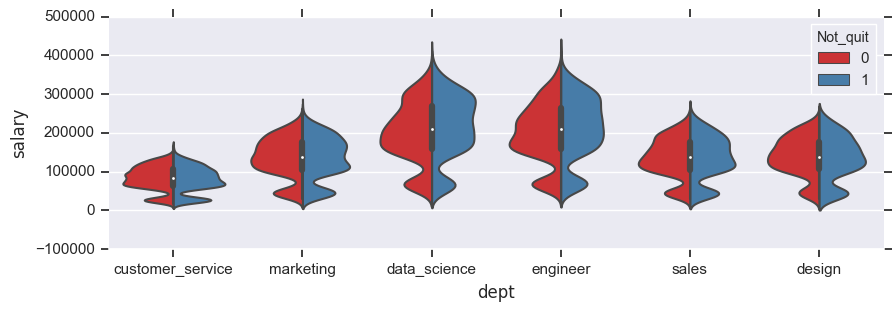

In [106]:
plt.figure(figsize=(10,3))
quit = (df.Not_quit == 0)
not_quit = (df.Not_quit == 1)

sns.set(palette="Set1")
sns.violinplot(x="dept", y="salary", hue="Not_quit",split=True,data=df)
sns.despine(left=True)
plt.show()

# plt.figure(figsize=(10,10))
# sns.violinplot(y='dept',x='salary',data=df,hue='status')

## Summarizing all plots here in table   <a name='Summary table'></a>

In [105]:
df.groupby(['dept','Not_quit'])['salary','seniority','years_worked'].agg(['mean','median'])

salary            seniority         \
                                    mean    median       mean median   
dept             Not_quit                                              
customer_service 0          84322.143698   86000.0  14.536317   15.0   
                 1          79656.387665   81000.0  13.715859   13.0   
data_science     0         199263.376932  199000.0  13.498216   13.0   
                 1         215387.931034  221000.0  14.959549   15.0   
design           0         139886.889460  141000.0  14.566838   14.0   
                 1         134325.581395  137000.0  13.720930   13.0   
engineer         0         198901.354784  200000.0  13.630398   13.0   
                 1         212515.326522  219000.0  14.703243   15.0   
marketing        0         136673.022995  139000.0  14.118901   14.0   
                 1         134213.150289  137000.0  13.770954   14.0   
sales            0         135638.321369  136000.0  13.966317   13.0   
                 1         136277.002204  138000.0  13.997796   13.0   

                          years_worked         
                                  mean median  
dept             Not_quit                      
customer_service 0            1.649965   1.14  
                 1            1.402384   1.13  
data_science     0            1.782753   1.22  
                 1            1.529695   1.28  
design           0            1.651478   1.16  
                 1            1.468887   1.28  
engineer         0            1.778823   1.28  
                 1            1.519178   1.32  
marketing        0            1.646096   1.14  
                 1            1.389863   1.07  
sales            0            1.591077   1.10  
                 1            1.416686   1.17

## Creating Models <a name='Creating Model'></a>


## Using Features : company_id,	seniority,	salary,	years_worked,	dept_code, getting outcome of wether an employee will quit or not.  <a name='WhoQuits'></a>

## STEP 1 Creating Final data  <a name='Creating Final data'></a>



** 1)  changing dept category variables to integers using code for each department **

In [21]:
df.dept = pd.Categorical(df.dept)
# Now the data look similar but are stored categorically. To capture the category codes:
df['dept_code'] = df.dept.cat.codes
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Not_quit,years_worked,dept_code
0,13021.0,7,customer_service,28.0,89000.0,2014-03-24,2015-10-30,0,1.602740,0
1,825355.0,7,marketing,20.0,183000.0,2013-04-29,2014-04-04,0,0.931507,4
2,927315.0,4,marketing,14.0,101000.0,2014-10-13,2015-12-13,1,1.167123,4
3,662910.0,7,customer_service,20.0,115000.0,2012-05-14,2013-06-07,0,1.065753,0
4,256971.0,2,data_science,23.0,276000.0,2011-10-17,2014-08-22,0,2.849315,1


** 2) removing columns that we dont need **

In [111]:
# df.pop('quit_date')
# df.pop('join_date')
# df.pop('employee_id')
# df.pop('dept')

df = df.drop(columns = ['employee_id', 'join_date', 'quit_date', 'dept'])

df.head()

,company_id,seniority,salary,Not_quit,years_worked
0,7,28.0,89000.0,0,1.60
1,7,20.0,183000.0,0,0.93
2,4,14.0,101000.0,1,1.17
3,7,20.0,115000.0,0,1.07
4,2,23.0,276000.0,0,2.85


In [113]:
final_data=df
#save as model_ready table
# final_data.to_csv('Data_Challenge_EmployeeRetention/model_ready.csv',index=False)

final_data.shape


(24702, 5)

** 3) Split Dataset **

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc

In [114]:
X = final_data.drop('Not_quit',axis=1)
y = final_data['Not_quit']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=1234)
print( len(X_train), len(X_test), len(y_train), len(y_test) )
print(y_train.head())
X.head()

19761 4941 19761 4941
13383    0
1096     0
20033    0
604      1
14972    0
Name: Not_quit, dtype: int32


,company_id,seniority,salary,years_worked
0,7,28.0,89000.0,1.60
1,7,20.0,183000.0,0.93
2,4,14.0,101000.0,1.17
3,7,20.0,115000.0,1.07
4,2,23.0,276000.0,2.85


## STEP 2 Model Pipeleine  <a name='Model Pipeleine'></a>

** Logistic Regression **

** Random forest **

In [119]:
#Standard scaler might be needed in logistic regression, not in RF, so 
# so just adding it in both pipeline, as it doesnt affect performance anyway.

pipelines = {
    'logistic' : make_pipeline(StandardScaler(), LogisticRegression(random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
}


** Tuning hyperparameters **
- Logistic egression: adjusting C 
- Random Forest : adjusting n_estimators and max features

In [123]:
# print(pipelines['logistic'].get_params().keys())
# print('\n')
# print(pipelines['rf'].get_params().keys())

logistic_hyperparameters={'logisticregression__C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
rf_hyperparameters={'randomforestclassifier__n_estimators':[10,20,40],
                   'randomforestclassifier__max_features':['auto', 'sqrt', 0.5]}

hyperparameters= {'logistic':logistic_hyperparameters,
                 'rf':rf_hyperparameters}

In [134]:
# model = GridSearchCV(pipelines['logistic'], hyperparameters['logistic'], cv=10, n_jobs=-1)
# model

fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV (pipelines[name],hyperparameters[name],
                          cv=10, n_jobs=-1)
        
    # Store model in fitted_models[name] 
    fitted_models[name] = model.fit(X_train,y_train)

    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

C:\Users\PG\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\PG\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\PG\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic has been fitted.


C:\Users\PG\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\PG\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


** Model Evaluation **

In [152]:
# fitted_models

In [135]:
# Display best_score_ for each fitted model
# in this case the best_score_ is the mean_accuracy of two classes
for name, model in fitted_models.items():
    print( name, model.best_score_ )

logistic 0.6338748039066849
rf 0.7601842012043925


C:\Users\PG\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\PG\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


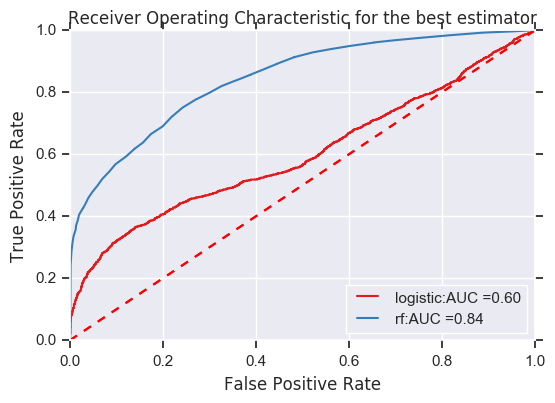

In [137]:
#ok look at the ROC curve
for key, model in fitted_models.items():
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic for the best estimator')
    plt.plot(fpr, tpr,label = '{}:AUC ={:.2f}'.format(key,roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    

## Random foreset performs a bit better than logistic regression   <a name='RFModel'></a>

**RF Model **

** 1) Checking  Accuracy **

In [145]:
rfc = RandomForestClassifier()
rfc.fit(X_train,list(y_train.values))

print('accuracy_score: %.3f'%(accuracy_score(list(y_test.values),rfc.predict(X_test))))
cm=confusion_matrix(list(y_test.values),rfc.predict(X_test))
cm=(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
cm


C:\Users\PG\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy_score: 0.763


array([[0.85244704, 0.14755296],
       [0.34906945, 0.65093055]])

** 2) Feature Importances**   

The most important feature is the years worked at the company and salary



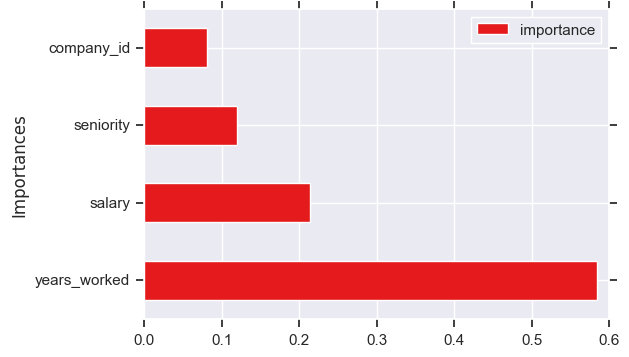

In [147]:
fea_imp = pd.DataFrame(
    rfc.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)
# fea_imp
ax = fea_imp.plot(kind='barh')
ax.set_ylabel('Importances')


** 4) Classification report on On testing data **



In [148]:
predictions = rfc.predict(X_test)
print('classification reports:',classification_report(list(y_test.values),predictions))


classification reports:               precision    recall  f1-score   support

           0       0.75      0.85      0.80      2738
           1       0.78      0.65      0.71      2203

   micro avg       0.76      0.76      0.76      4941
   macro avg       0.77      0.75      0.75      4941
weighted avg       0.76      0.76      0.76      4941



**  5) visualizing confusion_matrix and ROC Matrix**   


In [154]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_roc(fpr, tpr, roc_auc):
    lw = 2
    plt.plot(fpr, tpr, color = 'darkorange',
             lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")

Normalized confusion matrix
[[0.85244704 0.14755296]
 [0.34906945 0.65093055]]


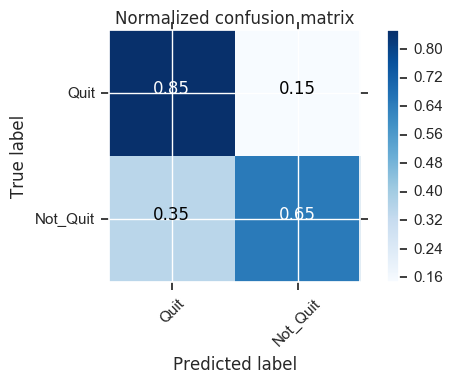

In [149]:
cnf_matrix = confusion_matrix(list(y_test.values),predictions)
class_names=  ['Quit','Not_Quit']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

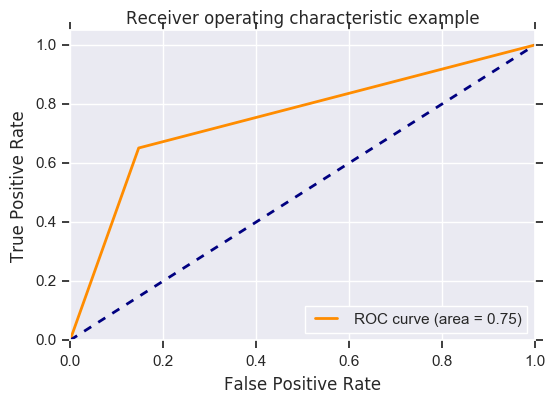

In [151]:
from sklearn.metrics import roc_curve, auc

plt.figure()
fpr, tpr, _ = roc_curve(list(y_test.values),predictions)
plot_roc(fpr, tpr, auc(fpr, tpr))
plt.show()


In the ROC curve below with an AUC of 0.75, for TPR ~0.65 and FPR ~ 0.18 is the operating point a company would choose to intervene  with strategy in keeping an employee.

## Conclusion:  <a name='conclusion'></a>





Overall, the company needs to focus on a range of factors to increase employee retention. A generalized solution cannot be applied to all departments or companies. 
It is noticed that employees in 50K to 200K , within 1-2 years of employments, and more than 5 years of seniority quit more.
Employees in customer service, marketing and sales with salaries lower than 200K quit more 
Employees in Data scenie and Engineering with salaries in 150K- 250K quit more
Also, company 12 in speciifc, has trouble with low salories and more quitting

For predicting which employees  quit, Running a random forest classifier on the the final data gives an accuracy of 0.75

So we are able to determine who quits based on salary and years_worked,	department with more emphasis on salary, but we definitely need more  data to create a more robust model.Using other models like XGBoost or techniques like Survival analysis would also be better here . And getting more data on personnel will enable a better tailored strategy